In [1]:
import os
import string
from time import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from difflib import SequenceMatcher
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from statistics import mean

import gensim
from gensim.models.doc2vec import Doc2Vec
from sentence_transformers import SentenceTransformer

from tensorflow_estimator.python.estimator.canned.dnn import dnn_logit_fn_builder
import tensorflow_hub as hub
import tensorflow as tf

import multiprocessing
from multiprocessing import Pool, cpu_count

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import sent_tokenize


nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('punkt')

stop_words = stopwords.words('english')

lemmatizer = WordNetLemmatizer()

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

def preprocess(sentence):
    return [w for w in sentence.lower().split() if w not in stop_words]


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
all_lines = []
directory = 'factiva_articles/'
for file in os.listdir(directory):
    
    f = open(directory + file, "r")
    lines = f.readlines()
    
    all_lines.extend(lines)
    

# Extracting individual articles from the entire corpus
total_article_count = 0
articles_used = 0

# Temporary string for storing each article
temp_string = """"""

# List of all articles
all_articles = []

# Temporary list that stores each article as separate lines in order to determine the article's line count
temp_lines = []


for line in all_lines:
    
    # "Document " followed by a code signals the end of an article
    if 'Document ' in line: 
        
        total_article_count += 1
        # If this article's line count is greater than 10, only then save it
        if len(temp_lines) > 10:
            
            # Keeping count of the number of articles used
            articles_used += 1
            
            #print(len(temp_lines))
            all_articles.append(temp_string)
            
        # Reset temp variables
        temp_lines = []
        temp_string = """"""
    
    # Keep updating temp variables
    else:
        temp_string += line
        temp_lines.append(line)
        
# Print count of articles        
print(total_article_count)
print(articles_used)


# Sanity check and removing unnecessary information from articles
sanitized_article_count = 0
all_articles_sanitized = []

for article in all_articles:
    
    # Get the first double line break index after the initial line breaks (starting after index 10)
    start_index = article.index("\n\n", 10)
    # Get the next double line break that's the start_index + 4 (4 characters - \n\n)
    end_index = article.index("\n\n", start_index + 4)
    
    # Sanity_check to make sure we're removing the correct information and not important information in the article
    if '504' in article[start_index:end_index]:
        sanitized_article_count += 1
    else: 
        print(start_index)
        print(end_index)
        print(article[start_index:end_index])
        #print(article)
        
    # Create new string that removes this substring from start_index to end_index
    new_article = article[0 : start_index : ] + article[end_index + 1 : :]
    
    # Replace all new lines with spaces
    new_article = new_article.replace('\n', ' ')
    
    new_article = new_article.strip(" ")
    
    # Add this article to list of sanitized articles
    all_articles_sanitized.append(new_article)
    
print(sanitized_article_count)


# Loading financial wellbeing df
finance_df = pd.read_excel("Fin_Wellbeing_subsample.xlsx")
finance_df = finance_df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Matching article titles from financial wellbeing excelsheet to articles in sanitized articles list
title_found = False
article_found_count = 0

article_dicts = [] 
for article_title in finance_df['article_title']:
    
    article_title = article_title.strip(" ")
    article_title_list = article_title.split(" ")
    title_first_word = article_title_list[0]   
    title_found = False
    print("")
    print("-------------------------------NEW ARTICLE----------------------------------------")
    print("Article title: "+article_title)
    
    
    for article in all_articles_sanitized:
        
        article_list = article.split(" ")
        
        first_word_found_before = False
        for word in article_list[0:30]:
            
            if title_found == True:
                break
                
            first_word_similarity = similar(title_first_word, word)
            
            if first_word_similarity > 0.9:
                
                print(f"FIRST WORD MATCH FOUND: {title_first_word}, {word}, {first_word_similarity}")
                #print(title_first_word, word, first_word_similarity)
                
                if first_word_found_before == False:
                    start_index = article.index(word)
                    
                else:
                    start_index = article[start_index+len(word):].index(word)
                
                title_similarity = similar(article_title, article[start_index:start_index + len(article_title)])
                print("Sentence:       "+ article[start_index:start_index + len(article_title)])
                print("Sentence Similarity: " +str(title_similarity))
                
                first_word_found_before = True
                if title_similarity > 0.9:
                    title_found = True
                    article_found_count += 1
                    new_dict = {}
                    
                    new_dict["article_title"] = article_title
                    new_dict["text"] = article
                    #print(finance_df[finance_df["article_title"] == article_title]["relevant_campbell"])
                    new_dict["relevant_campbell"] = finance_df[finance_df["article_title"] == article_title]["relevant_campbell"].values[0]
                    new_dict["relevant_kristen"] = finance_df[finance_df["article_title"] == article_title]["relevant_kristen"].values[0]
                    new_dict["mismatch"] = finance_df[finance_df["article_title"] == article_title]["mismatch"].values[0]
                    
                    article_dicts.append(new_dict)
                    break
                    
                else:
                    title_found = False
                    
            else:
                title_found = False
            
    print("-----------------------------------------------------------------------------------")
    
print(article_found_count)

# Creating a new df with article titles, article text and classifications
articles_df = pd.DataFrame(article_dicts)

# sanity check to ensure all the matched values for classifications by campbell and kristen across both dataframes match
for article_title in articles_df["article_title"]:
    if finance_df[finance_df["article_title"] == article_title]["relevant_campbell"].values[0] != articles_df[articles_df["article_title"] == article_title]["relevant_campbell"].values[0]:
        print("Error in relevant_campbell")
        print(article_title)
        print(finance_df[finance_df["article_title"] == article_title]["relevant_campbell"].values[0])
        print(articles_df[articles_df["article_title"] == article_title]["relevant_campbell"].values[0])

    if finance_df[finance_df["article_title"] == article_title]["relevant_kristen"].values[0] != articles_df[articles_df["article_title"] == article_title]["relevant_kristen"].values[0]:
        print("Error in relevant_kristen")
        print(article_title)
        print(finance_df[finance_df["article_title"] == article_title]["relevant_kristen"].values[0])
        print(articles_df[articles_df["article_title"] == article_title]["relevant_kristen"].values[0])

    if finance_df[finance_df["article_title"] == article_title]["mismatch"].values[0] != articles_df[articles_df["article_title"] == article_title]["mismatch"].values[0]:
        print("Error in mismatch")
        print(article_title)
        print(finance_df[finance_df["article_title"] == article_title]["mismatch"].values[0])
        print(articles_df[articles_df["article_title"] == article_title]["mismatch"].values[0])

        

1388
1366
134
279


NEW YORK, April 10, 2019 /PRNewswire/ -- ERISA wrap document provider, Clarity Benefit Solutions, discusses the importance of ERISA compliance.
182
583


RICH KAPELKE SPOKANE DRIVERS IGNORING RULES I feel that many will attest to studying the driver's manual to obtain their licenses, and afterward ignoring the basic rules of the road once they have license in hand.In adverse weather conditions and during either dusk or dawn, no driver has headlights on.The proponents of the program should form a health care company and sell one product, Obamacare.
172
547


David Tiller, Head of Adviser Propositions and Strategy at Standard Life, said: "We really have entered the golden age for advisers who now have the opportunity to provide more of the population with advice when they need it most. This need has never been greater and it is vitally important the industry works together to ensure that people can access the help they need."
129
321


IT'S really to draw attention to

FIRST WORD MATCH FOUND: Couple, Couple, 1.0
Sentence:       Couple who bought B&Q plant for just £12 discover its leaves are worth £170 each
Sentence Similarity: 1.0
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: Drivers face £35bn tax bill to plug the gap as switch to electric cars hits revenue
FIRST WORD MATCH FOUND: Drivers, Drivers, 1.0
Sentence:       Drivers face £35bn tax bill to plug the gap as switch to electric cars hits revenue
Sentence Similarity: 1.0
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: Sultan ‘partner’ joins will battle
FIRST WORD MATCH FOUND: Sultan, Sultan, 1.0
Sentence:       Sultan 'partner' joins will battle
Sentence Similarity: 0.9411764705882353
-------------------------------------------

-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: SCAM ALERT: LOAN REPAYMENT COMPANIES SCAMMING STUDENTS, CHARGING THEM FOR SERVICES AVAILABLE FOR FREE
FIRST WORD MATCH FOUND: SCAM, SCAM, 1.0
Sentence:       SCAM ALERT: LOAN REPAYMENT COMPANIES SCAMMING STUDENTS, CHARGING THEM FOR SERVICES AVAILABLE FOR FREE
Sentence Similarity: 1.0
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: State Pension age changes could affect when you will be able to retire - check yours now
FIRST WORD MATCH FOUND: State, State, 1.0
Sentence:       State College ; St Joseph, MO - news  By  (The Center Square) - President Joe Biden tout
Sentence Similarity: 0.2727272727272727
FIRST WORD MATCH FOUND: State, States, 0.9090909090909091
Sentence:      

FIRST WORD MATCH FOUND: More, More, 1.0
Sentence:       More than three people in four will be seeing in 2017 at home - either quietly or surrounded by friends - but this could quickly turn int
Sentence Similarity: 0.2773722627737226
FIRST WORD MATCH FOUND: More, More, 1.0
Sentence:       More than half a billion pounds are being handed over every year in inheritance tax from life insurance policies because people aren't pl
Sentence Similarity: 0.29927007299270075
FIRST WORD MATCH FOUND: More, More, 1.0
Sentence:       More Expensive Than You Think: Monday's Retirement Scan Our daily roundup of retirement news your clients may be thinking about.  Retirem
Sentence Similarity: 0.2846715328467153
FIRST WORD MATCH FOUND: More, More, 1.0
Sentence:       More study If ever there was a deep wedge driven between the federal government and the provinces, the one over pension reform could like
Sentence Similarity: 0.39416058394160586
FIRST WORD MATCH FOUND: More, More, 1.0
Sentence:       More p

FIRST WORD MATCH FOUND: Sunwing, Sunwing, 1.0
Sentence:       Sunwing offers long-awaited deals with significant savings on vacations at RIU Hotels & Resorts
Sentence Similarity: 1.0
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: What cinemas will look like after lockdown -with special areas for social bubbles
FIRST WORD MATCH FOUND: What, What, 1.0
Sentence:       What did the High Court in Hill v Zuda decide about binding death benefit nominat
Sentence Similarity: 0.30864197530864196
FIRST WORD MATCH FOUND: What, What, 1.0
Sentence:       What pension options are available? I'm approaching retirement and due to stop wo
Sentence Similarity: 0.2716049382716049
FIRST WORD MATCH FOUND: What, What, 1.0
Sentence:       What happens when worker benefits are cut? Some suggest that workers offset benef
Sentence Similarity: 0.38271604938271603
FIRST WORD MATCH

FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The ongoing investigati
Sentence Similarity: 0.30434782608695654
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The number of funds com
Sentence Similarity: 0.4782608695652174
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The number of funds com
Sentence Similarity: 0.4782608695652174
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The Sun, and the C4 sho
Sentence Similarity: 0.34782608695652173
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The Property Report For
Sentence Similarity: 0.34782608695652173
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       or The pandemic came at
Sentence Similarity: 0.34782608695652173
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The five best places to
Sentence Similarity: 0.391304347826087
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The crisis is laid bare
Sentence Similarity: 0.2608695652173913
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:      

FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The pressure on family 
Sentence Similarity: 0.43478260869565216
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The two-week government
Sentence Similarity: 0.391304347826087
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The private equity back
Sentence Similarity: 0.391304347826087
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The Latest Getaway Holi
Sentence Similarity: 0.34782608695652173
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The impact of divorce o
Sentence Similarity: 0.43478260869565216
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The booking cost was di
Sentence Similarity: 0.2608695652173913
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The TSX hit a six-week 
Sentence Similarity: 0.30434782608695654
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       Then call MPAC KIRK DIC
Sentence Similarity: 0.34782608695652173
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:      

FIRST WORD MATCH FOUND: Landlords, Landlords, 1.0
Sentence:       Landlords charge 'pet rent' to recoup losses after ban on unfair fees
Sentence Similarity: 1.0
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: Advice fees vary by 1,000 per cent
FIRST WORD MATCH FOUND: Advice, Advice, 1.0
Sentence:       Advice column: Mortgage Advice Bur
Sentence Similarity: 0.35294117647058826
FIRST WORD MATCH FOUND: Advice, Advice, 1.0
Sentence:       vice column: Mortgage Advice Burea
Sentence Similarity: 0.2647058823529412
FIRST WORD MATCH FOUND: Advice, Advice, 1.0
Sentence:       Advice column: Mortgage Advice Bur
Sentence Similarity: 0.35294117647058826
FIRST WORD MATCH FOUND: Advice, Advice, 1.0
Sentence:       Advice fees vary by 1,000 per cent
Sentence Similarity: 1.0
-----------------------------------------------------------------------------------

---------

FIRST WORD MATCH FOUND: SMART, SMART, 1.0
Sentence:       SMART Note      504 words 3 April 2006
Sentence Similarity: 0.3684210526315789
FIRST WORD MATCH FOUND: SMART, SMART, 1.0
Sentence:       SMART FUNDS  A five-year performance c
Sentence Similarity: 0.3157894736842105
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: Anne Meiring, Anthony Clarizio and Sheri Kittelson: Don't wait to make end-of-life plans
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: Kiplinger's Personal Finance: How to trim your car, home and health insurance premiums
FIRST WORD MATCH FOUND: Kiplinger's, Kiplinger's, 1.0
Sentence:       Kiplinger's latest forecast on interest rates..article ul.kip-eo-mlinks { color: #ccc;
Sentence Similarity: 0.3255

FIRST WORD MATCH FOUND: New, New, 1.0
Sentence:       New saving rules  hang on to y
Sentence Similarity: 0.43333333333333335
FIRST WORD MATCH FOUND: New, New, 1.0
Sentence:       New law takes effect in 6 mont
Sentence Similarity: 0.4
FIRST WORD MATCH FOUND: New, New, 1.0
Sentence:       New Zealand Superannuation Fun
Sentence Similarity: 0.3
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: As You Prepare Your 2017 Tax Return, Don't Forget Saving for College Can Have Tax Benefits
FIRST WORD MATCH FOUND: As, As, 1.0
Sentence:       As we enter 2020, it's amazing how the media, and many investors, begin with such a negati
Sentence Similarity: 0.3333333333333333
FIRST WORD MATCH FOUND: As, As, 1.0
Sentence:       As Stock Nears Buy Point: Investing Action Plan Here's your Investing Action Plan for Tues
Sentence Similarity: 0.28888888888888886
FIRST WORD MA

FIRST WORD MATCH FOUND: Pension, Pensions, 0.9333333333333333
Sentence:       Pensions Relief for final salary members as pension deficits
Sentence Similarity: 0.3333333333333333
FIRST WORD MATCH FOUND: Pension, Pensions, 0.9333333333333333
Sentence:       Pensions Committee will examine events  Executives from coll
Sentence Similarity: 0.26666666666666666
FIRST WORD MATCH FOUND: Pension, Pensions, 0.9333333333333333
Sentence:       Pensions Tide of consultation on the way as minister indicat
Sentence Similarity: 0.38333333333333336
FIRST WORD MATCH FOUND: Pension, Pensions, 0.9333333333333333
Sentence:       Pensions Lloyds acquires Zurich's workplace pensions and sav
Sentence Similarity: 0.21666666666666667
FIRST WORD MATCH FOUND: Pension, Pension, 1.0
Sentence:       Pension fund moves into riskier investments; Venture Capital
Sentence Similarity: 1.0
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE------

FIRST WORD MATCH FOUND: How, How, 1.0
Sentence:       How to get top dollar for your
Sentence Similarity: 0.5666666666666667
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: Online firm pairs home buyers, sellers with realtors
FIRST WORD MATCH FOUND: Online, Online, 1.0
Sentence:       Online Community Colleges for 2021  Degree holders g
Sentence Similarity: 0.36538461538461536
FIRST WORD MATCH FOUND: Online, Online, 1.0
Sentence:       Online Trade Clearance Process, an Equity Compensati
Sentence Similarity: 0.4423076923076923
FIRST WORD MATCH FOUND: Online, Online, 1.0
Sentence:       Online Orders  504 words 21 December 2019 02:40 AM P
Sentence Similarity: 0.3076923076923077
FIRST WORD MATCH FOUND: Online, Online, 1.0
Sentence:       Online shoppers urged to beware of scams in rush to 
Sentence Similarity: 0.38461538461538464
FIRST WORD MATCH FOUND: O

FIRST WORD MATCH FOUND: Tax, Tax, 1.0
Sentence:       Tax Talk Today Features IRS and Tax Pros Presenting, "Ready, Set, Retire! Helping Your Aging and Elderly Clients"
Sentence Similarity: 1.0
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: MARKET MOVERS THOMAS WELLS & PAUL PARASCANDALO
FIRST WORD MATCH FOUND: MARKET, MARKET, 1.0
Sentence:       MARKET WATCHLIST: Will coronavirus take its to
Sentence Similarity: 0.30434782608695654
FIRST WORD MATCH FOUND: MARKET, MARKET, 1.0
Sentence:       MARKET MOVER PAUL O'BRIEN Paul O'Brien is head
Sentence Similarity: 0.43478260869565216
FIRST WORD MATCH FOUND: MARKET, MARKETS, 0.9230769230769231
Sentence:       MARKETS & INVESTING Foreign gilt buying soars 
Sentence Similarity: 0.2391304347826087
FIRST WORD MATCH FOUND: MARKET, MARKET, 1.0
Sentence:       MARKET MOVERS THOMAS WELLS & PAUL PARASCANDALO
Sentence Si

-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: Central School Board to ask voters to renew property tax
FIRST WORD MATCH FOUND: Central, Central, 1.0
Sentence:       Central Bank official said the world economy faces "an a
Sentence Similarity: 0.32142857142857145
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: No hike in benefits next year for Social Security recipients
FIRST WORD MATCH FOUND: No, No, 1.0
Sentence:       No - we do not.  In the United States, death tax is required
Sentence Similarity: 0.38333333333333336
FIRST WORD MATCH FOUND: No, No, 1.0
Sentence:       No room for emotional baggage SENTIMENTAL KEEPSAKES WON'T HE
Sentence Similarity: 0.26666666666666666
FIRST WORD MATCH FOUND: No, No, 1.0
Sentence:   

FIRST WORD MATCH FOUND: Press, Press, 1.0
Sentence:       Press LNDNFP Final N7 English Copyright © 2017 The London Free Pres
Sentence Similarity: 0.34328358208955223
FIRST WORD MATCH FOUND: Press, Press, 1.0
Sentence:        January 2017 The London Free Press LNDNFP Final N7 English Copyrig
Sentence Similarity: 0.2537313432835821
FIRST WORD MATCH FOUND: Press, Press, 1.0
Sentence:       Press Release: Stull, Stull & Brody is Investigating Claims on Beha
Sentence Similarity: 0.3880597014925373
FIRST WORD MATCH FOUND: Press, Press, 1.0
Sentence:       Press Release/Statement:  Headline: Treasury Announces Partnership 
Sentence Similarity: 0.44776119402985076
FIRST WORD MATCH FOUND: Press, Press, 1.0
Sentence:       Press Release/Statement  Headline: Boost in overseas student loan r
Sentence Similarity: 0.4626865671641791
FIRST WORD MATCH FOUND: Press, Press, 1.0
Sentence:       Press Release: Health Insurance Innovations, Inc. to Announce Fourt
Sentence Similarity: 0.5074626865671642
FI

FIRST WORD MATCH FOUND: Will, Will, 1.0
Sentence:       Will Bolster Retirement Security for More Than 1 
Sentence Similarity: 0.3469387755102041
FIRST WORD MATCH FOUND: Will, Will, 1.0
Sentence:       Will He Be Tapped for Biden's Cabinet? Roger Ferg
Sentence Similarity: 0.42857142857142855
FIRST WORD MATCH FOUND: Will, Will, 1.0
Sentence:       Will coronavirus take its toll on Ministers' NatW
Sentence Similarity: 0.16326530612244897
FIRST WORD MATCH FOUND: Will, Will, 1.0
Sentence:       Will Help Teens Understand the Importance of Inve
Sentence Similarity: 0.42857142857142855
FIRST WORD MATCH FOUND: Will, Will, 1.0
Sentence:       Will and how you can make a donation to charity T
Sentence Similarity: 0.3469387755102041
FIRST WORD MATCH FOUND: Will, Will, 1.0
Sentence:       Will Congress Update the Higher Education Act?(ST
Sentence Similarity: 0.3673469387755102
FIRST WORD MATCH FOUND: Will, Will, 1.0
Sentence:       Will Stay Intact: ERISA Attorney Wagner ERISA att
Sentence Simila

FIRST WORD MATCH FOUND: New, New, 1.0
Sentence:       New Program to Support Money to Student Emergency Fund Through Cookie Sales ORLANDO, Fla., February 26, 2021, /3BL Media/
Sentence Similarity: 0.2727272727272727
FIRST WORD MATCH FOUND: New, New, 1.0
Sentence:       New Jersey electric utilities have proposed changing their customers meters to digitally networked ones since the state m
Sentence Similarity: 0.2975206611570248
FIRST WORD MATCH FOUND: New, New, 1.0
Sentence:       New York and Chicago, including Stephen Liss, a former UBS strategist who advised high-net-worth families.  Liss joined S
Sentence Similarity: 0.3140495867768595
FIRST WORD MATCH FOUND: New, New, 1.0
Sentence:       New "Retire4Real" Online Game Will Help Teens Understand the Importance of Investing for Retirement Junior Achievement an
Sentence Similarity: 0.371900826446281
FIRST WORD MATCH FOUND: New, New, 1.0
Sentence:       News Advice fees vary by 1,000 per cent New research highlights significant diverge

FIRST WORD MATCH FOUND: Drive, Drive, 1.0
Sentence:       Drive a hard bargain; HAVE PASSPORT WILL TRAVEL Jeremy Gates rounds up all the latest travel news
Sentence Similarity: 1.0
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: A brighter future is now within reach; Workplace pensions Advertising Feature
FIRST WORD MATCH FOUND: A, A, 1.0
Sentence:       ATES FILE A CHALLENGE TO THE BIDEN ADMINISTRATION'S STUDENT LOAN CANCELLATION
Sentence Similarity: 0.1038961038961039
FIRST WORD MATCH FOUND: A, A, 1.0
Sentence:       A GOP attorney general says people are 'celebrating prematurely' Biden's stud
Sentence Similarity: 0.3246753246753247
FIRST WORD MATCH FOUND: A, A, 1.0
Sentence:       Adviser Corner RETIREMENT: A step toward solving the retirement-savings gap; 
Sentence Similarity: 0.2727272727272727
FIRST WORD MATCH FOUND: A, A, 1.0
Sentence:       A SC

FIRST WORD MATCH FOUND: Charge, Charge, 1.0
Sentence:       Charge investors higher rate
Sentence Similarity: 0.42857142857142855
FIRST WORD MATCH FOUND: Charge, Charges, 0.9230769230769231
Sentence:       Charges Financial Advisor wi
Sentence Similarity: 0.42857142857142855
FIRST WORD MATCH FOUND: Charge, Charge, 1.0
Sentence:       Charge Cards vs. Debit Cards
Sentence Similarity: 1.0
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: New house sales build
FIRST WORD MATCH FOUND: New, New, 1.0
Sentence:       New petition calls fo
Sentence Similarity: 0.47619047619047616
FIRST WORD MATCH FOUND: New, New, 1.0
Sentence:       New Financial Behavio
Sentence Similarity: 0.38095238095238093
FIRST WORD MATCH FOUND: New, New, 1.0
Sentence:       New York, a live even
Sentence Similarity: 0.38095238095238093
FIRST WORD MATCH FOUND: New, New, 1.0
Sentence:       

FIRST WORD MATCH FOUND: Why, Why, 1.0
Sentence:       Why divorce is bad for a man's health: Separation increases the risk of early death, substance abuse, suicide and depression
Sentence Similarity: 1.0
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: FEAR FOR ELDERLY WITH MORTGAGE DEBT
FIRST WORD MATCH FOUND: FEAR, FEAR, 1.0
Sentence:       FEAR FOR ELDERLY WITH MORTGAGE DEBT
Sentence Similarity: 1.0
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: Schedule your winter travel excursions now
FIRST WORD MATCH FOUND: Schedule, Scheduled, 0.9411764705882353
Sentence:       Scheduled for Thursday, March 5, 2020 at 1
Sentence Similarity: 0.38095238095238093
----------------------------------------------------------------------

FIRST WORD MATCH FOUND: Compulsory, Compulsory, 1.0
Sentence:       Compulsory pension for West workers
Sentence Similarity: 1.0
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: Three Tips For Building A Lasting Retirement
FIRST WORD MATCH FOUND: Three, Three, 1.0
Sentence:       Three fifths (61%) say they have had to scra
Sentence Similarity: 0.2727272727272727
FIRST WORD MATCH FOUND: Three, Three, 1.0
Sentence:       Three Tips For Building A Lasting Retirement
Sentence Similarity: 1.0
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: Certified COBRA Administrator COBRAGuard Inc. Awarded Contract with State of North Carolina
FIRST WORD MATCH FOUND: Certified, Certified, 1.0
Sentence:       Certified Financial Planner Boa

-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: Grown-Up Spring Break Spots
FIRST WORD MATCH FOUND: Grown-Up, Grown-Up, 1.0
Sentence:       Grown-Up Spring Break Spots
Sentence Similarity: 1.0
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: Should I use lump sum to pay off mortgage or save for children's studies?
FIRST WORD MATCH FOUND: Should, Should, 1.0
Sentence:       Should Be Allowed to Consider Climate Change, Other ESG Factors in Invest
Sentence Similarity: 0.3424657534246575
FIRST WORD MATCH FOUND: Should, Should, 1.0
Sentence:       Should Indian investors consider US stock market investment from India? I
Sentence Similarity: 0.3150684931506849
FIRST WORD MATCH FOUND: Should, Should, 1.0
Sentence:       Should 

FIRST WORD MATCH FOUND: New, New, 1.0
Sentence:       News New report reveals older worker hotspots and the vast differences in employment prospects for over 50s around the country Watford, Dorse
Sentence Similarity: 0.19858156028368795
FIRST WORD MATCH FOUND: New, New, 1.0
Sentence:       New home affordability remains a prime concern This week's topic is the first in a series concerning issues affecting the residential constru
Sentence Similarity: 0.23404255319148937
FIRST WORD MATCH FOUND: New, New, 1.0
Sentence:       New York Modern Dance Company in Search of a Space to Call Its Own; Hope Greenfield Donates $500,000 to Rioult Dance NY Hope Greenfield belie
Sentence Similarity: 0.2198581560283688
FIRST WORD MATCH FOUND: New, New, 1.0
Sentence:       New Hires Address New Business Opportunities and Current Relationships     OAK BROOK, Ill., Feb. 26, 2014 /PRNewswire-iReach/ -- Millennium T
Sentence Similarity: 0.2695035460992908
FIRST WORD MATCH FOUND: New, New, 1.0
Sentence:       

FIRST WORD MATCH FOUND: Cloud, Cloud, 1.0
Sentence:       Cloud of debt lifted through financial coaching program
Sentence Similarity: 1.0
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: Labor helps union, nonunion jobless
FIRST WORD MATCH FOUND: Labor, Labour, 0.9090909090909091
Sentence:       Labour Force Participation, Retirem
Sentence Similarity: 0.42857142857142855
FIRST WORD MATCH FOUND: Labor, Labor, 1.0
Sentence:       Labor (DOL) published its proposal1
Sentence Similarity: 0.37142857142857144
FIRST WORD MATCH FOUND: Labor, Labor, 1.0
Sentence:       Labor fiduciary rule will prevail, 
Sentence Similarity: 0.34285714285714286
FIRST WORD MATCH FOUND: Labor, Labor, 1.0
Sentence:       Labor Department rule PNC Investmen
Sentence Similarity: 0.37142857142857144
FIRST WORD MATCH FOUND: Labor, Labor, 1.0
Sentence:       Labor has enacted a number o

FIRST WORD MATCH FOUND: Consolidation, Consolidation, 1.0
Sentence:       Consolidation loans - not the easy way out
Sentence Similarity: 1.0
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: Mortgage squeeze tightens after Abbey clamps down on interest-only deals
FIRST WORD MATCH FOUND: Mortgage, Mortgages, 0.9411764705882353
Sentence:       Mortgages Buyers urged to house hunt now to save on stamp duty Homebuyer
Sentence Similarity: 0.25
FIRST WORD MATCH FOUND: Mortgage, Mortgage, 1.0
Sentence:       Mortgage Advice Bureau East Kilbride writes in the News Kevin McCarthy o
Sentence Similarity: 0.3472222222222222
FIRST WORD MATCH FOUND: Mortgage, Mortgage, 1.0
Sentence:       e writes in the News Kevin McCarthy of Mortgage Advice Bureau East Kilbr
Sentence Similarity: 0.2222222222222222
FIRST WORD MATCH FOUND: Mortgage, Mortgage, 1.0
Sentence:       Mortg

FIRST WORD MATCH FOUND: Women, Women, 1.0
Sentence:       Women to Watch Twenty-two women were r
Sentence Similarity: 0.42105263157894735
FIRST WORD MATCH FOUND: Women, Women, 1.0
Sentence:       Women still lack financial self esteem
Sentence Similarity: 1.0
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: BORROWERS TOLD TO ACT FAST OVER MORTGAGES
FIRST WORD MATCH FOUND: BORROWERS, BORROWERS, 1.0
Sentence:       BORROWERS TOLD TO ACT FAST OVER MORTGAGES
Sentence Similarity: 1.0
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: Dividing the spoils
FIRST WORD MATCH FOUND: Dividing, Dividing, 1.0
Sentence:       Dividing the spoils
Sentence Similarity: 1.0
----------------------------------------------------------------------

FIRST WORD MATCH FOUND: Money, Money, 1.0
Sentence:       Money 'Dodgy builders destroyed my home - t
Sentence Similarity: 0.3023255813953488
FIRST WORD MATCH FOUND: Money, Money, 1.0
Sentence:       Money Super Saturday set to see £1.65billio
Sentence Similarity: 0.37209302325581395
FIRST WORD MATCH FOUND: Money, Money, 1.0
Sentence:       Money Edited by Harvey Jones email: harvey.
Sentence Similarity: 0.3488372093023256
FIRST WORD MATCH FOUND: Money, Money, 1.0
Sentence:       Money LITTLE STAR Sainsbury's Christmas adv
Sentence Similarity: 0.32558139534883723
FIRST WORD MATCH FOUND: Money, Money, 1.0
Sentence:       Money Fake poppy sellers caught cashing in 
Sentence Similarity: 0.4186046511627907
FIRST WORD MATCH FOUND: Money, Money, 1.0
Sentence:       Money What mega millions lottery winners of
Sentence Similarity: 0.32558139534883723
FIRST WORD MATCH FOUND: Money, Money, 1.0
Sentence:       Money Mail TAKE THE HASSLE OUT OF SWITCHING
Sentence Similarity: 0.23255813953488372
FI

FIRST WORD MATCH FOUND: Money, Money, 1.0
Sentence:       Money Advice Service managed to cut the amo
Sentence Similarity: 0.4883720930232558
FIRST WORD MATCH FOUND: Money, Money, 1.0
Sentence:       Money Dreams of cracking the UK market Donn
Sentence Similarity: 0.3953488372093023
FIRST WORD MATCH FOUND: Money, Money, 1.0
Sentence:       Money Rates threat to negative gearing Insi
Sentence Similarity: 0.37209302325581395
FIRST WORD MATCH FOUND: Money, Money, 1.0
Sentence:       Money Technology can deliver big returns Un
Sentence Similarity: 0.3953488372093023
FIRST WORD MATCH FOUND: Money, Money, 1.0
Sentence:       Money Insurance is a risk when doing it you
Sentence Similarity: 0.46511627906976744
FIRST WORD MATCH FOUND: Money, Money, 1.0
Sentence:       Money Pages Money: Currency conversion is s
Sentence Similarity: 0.4186046511627907
FIRST WORD MATCH FOUND: Money, Money:, 0.9090909090909091
Sentence:       an Money Pages Money: Currency conversion i
Sentence Similarity: 0.39534

FIRST WORD MATCH FOUND: Where's, here's, 0.9230769230769231
Sentence:       here's what to buy LOVEHONEY has a
Sentence Similarity: 0.4117647058823529
FIRST WORD MATCH FOUND: Where's, here's, 0.9230769230769231
Sentence:       here's how much they're worth The 
Sentence Similarity: 0.47058823529411764
FIRST WORD MATCH FOUND: Where's, here's, 0.9230769230769231
Sentence:       here's how past lotto winners have
Sentence Similarity: 0.47058823529411764
FIRST WORD MATCH FOUND: Where's, here's, 0.9230769230769231
Sentence:       here's their top tipples under £20
Sentence Similarity: 0.4117647058823529
FIRST WORD MATCH FOUND: Where's, here's, 0.9230769230769231
Sentence:       here's our handy guide to reducing
Sentence Similarity: 0.4411764705882353
FIRST WORD MATCH FOUND: Where's, here's, 0.9230769230769231
Sentence:       here's one - you can improve your 
Sentence Similarity: 0.4117647058823529
FIRST WORD MATCH FOUND: Where's, Where's, 1.0
Sentence:       Where's the best place to get 

FIRST WORD MATCH FOUND: SL, SL, 1.0
Sentence:       SL venture capital firm creates list of top tech, biotech leaders
Sentence Similarity: 1.0
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: Upgrading your insurance without tax penalty
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: Hercules Sees Asbestos-Related Payments $40M-$45M In '04
FIRST WORD MATCH FOUND: Hercules, Hercules, 1.0
Sentence:       Hercules Sees Asbestos-Related Payments $40M-$45M In '04
Sentence Similarity: 1.0
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: Mad Cow Disease Risk Sparks Call For Wider Import Ban
FIRST 

FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The Insider Picks team writes about stuff we think you'll 
Sentence Similarity: 0.2413793103448276
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The pensions of savers in ill-health face the threat of in
Sentence Similarity: 0.39655172413793105
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The offer includes Cadbury Heroes and Celebrations as well
Sentence Similarity: 0.27586206896551724
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The glass ceiling, the gender pay gap, and women's pension
Sentence Similarity: 0.3275862068965517
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The price is right for a fight when it's $900m Dementia cl
Sentence Similarity: 0.2413793103448276
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The research shows the importance of choosing a firm which
Sentence Similarity: 0.3103448275862069
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The U.S. Department of Jus

Sentence:       The S&P/TSX Capped Financial index has returned only 2.7% 
Sentence Similarity: 0.25862068965517243
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The Ontario Municipal Board - better known as the OMB - do
Sentence Similarity: 0.3620689655172414
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The breathtaking announcement of vastly improved flexibili
Sentence Similarity: 0.29310344827586204
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The default rate of "sliced and diced" loans backed by com
Sentence Similarity: 0.27586206896551724
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The pressure on family budgets is showing signs of easing 
Sentence Similarity: 0.41379310344827586
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The two-week government shutdown in October delayed the U.
Sentence Similarity: 0.41379310344827586
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The private equity backers of Just Retirement have trimmed
Se

FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The investigation into Electricity North West Limited (ENW
Sentence Similarity: 0.3103448275862069
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The Financial Advisory Group in York. He answered some que
Sentence Similarity: 0.25862068965517243
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The Journal THEJOU 54 English (c) 2003 The Newcastle Chron
Sentence Similarity: 0.1896551724137931
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The self-builder - Ask the experts - Property. I want to b
Sentence Similarity: 0.3620689655172414
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The reason is usually due to the simple fact that they for
Sentence Similarity: 0.3275862068965517
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The meaning of the word has changed a lot since Sept. 11, 
Sentence Similarity: 0.3448275862068966
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The first set of monthly re

FIRST WORD MATCH FOUND: Rate, Rate, 1.0
Sentence:       Rate Int  No Notice Accounts or Term AER  Saga 08
Sentence Similarity: 0.3673469387755102
FIRST WORD MATCH FOUND: Rate, Rate, 1.0
Sentence:       Rates  KEY  AAA = Institution  BBB = Basic Rate  
Sentence Similarity: 0.12244897959183673
FIRST WORD MATCH FOUND: Rate, Rate, 1.0
Sentence:       gage Rates  KEY  AAA = Institution  BBB = Basic R
Sentence Similarity: 0.20408163265306123
FIRST WORD MATCH FOUND: Rate, Rate, 1.0
Sentence:       inance YOUR MONEY BORROWING WATCH Mortgage Rates 
Sentence Similarity: 0.12244897959183673
FIRST WORD MATCH FOUND: Rate, Rate, 1.0
Sentence:       Rate cuts put savers in hard place ; Those lookin
Sentence Similarity: 0.40816326530612246
FIRST WORD MATCH FOUND: Rate, Rate, 1.0
Sentence:       Rate cuts put savers in hard place ; Those lookin
Sentence Similarity: 0.40816326530612246
FIRST WORD MATCH FOUND: Rate, Rate, 1.0
Sentence:       Rate cut may remind some homeowners to refinance.
Sentence Simi

FIRST WORD MATCH FOUND: Pension, Pension, 1.0
Sentence:       Pension campaigners will stage a dem
Sentence Similarity: 0.4444444444444444
FIRST WORD MATCH FOUND: Pension, Pension, 1.0
Sentence:       Pension campaigners will stage a dem
Sentence Similarity: 0.4444444444444444
FIRST WORD MATCH FOUND: Pension, Pension, 1.0
Sentence:       Pension worry.   MONDAY MAGAZINE mon
Sentence Similarity: 0.2777777777777778
FIRST WORD MATCH FOUND: Pension, Pension, 1.0
Sentence:       Pension Fund   BERLIN -(Dow Jones)- 
Sentence Similarity: 0.3611111111111111
FIRST WORD MATCH FOUND: Pension, Pension, 1.0
Sentence:       Pension off AVC rules; The Last Word
Sentence Similarity: 1.0
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: Gold Stocks Favoured As Telecom, Bank Shares Fall
FIRST WORD MATCH FOUND: Gold, Gold, 1.0
Sentence:       Gold Standard Awards 2018; Reve

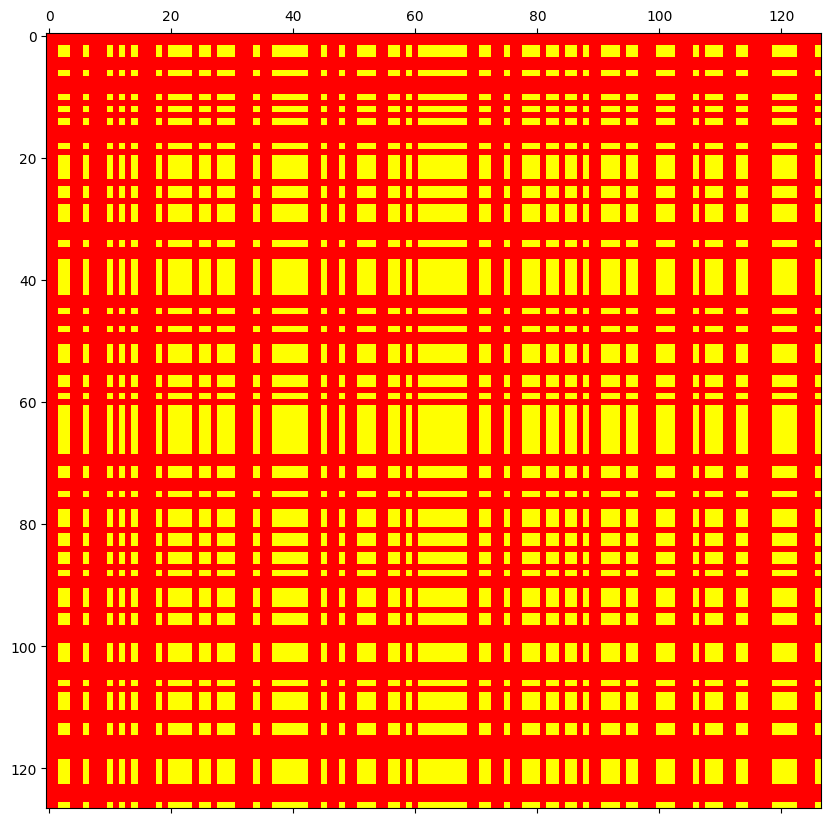

In [3]:
matrix = []
for index, row in articles_df.iterrows():
    
    temp_list = []
    
    if row['relevant_campbell'] == 1:
        
        for index, row in articles_df.iterrows():
            
            if row['relevant_campbell'] == 1:
                
                temp_list.append(1)
            
            else:
                
                temp_list.append(0)
                
    else:
        
        temp_list = list(np.zeros(len(articles_df)))
        
    
    matrix.append(temp_list)
    

plt.figure(figsize = (10,10))
plt.set_cmap('autumn')

plt.matshow(matrix, fignum=1)

plt.show()

In [4]:
start = time()

model = gensim.models.KeyedVectors.load_word2vec_format('wmd/GoogleNews-vectors-negative300.bin.gz', binary=True)
print('Cell took %.2f seconds to run.' % (time() - start))



Cell took 123.70 seconds to run.


In [8]:
def process_wmd_similarity(base_document, documents, temp_list, max_similarity, min_similarity, count):
    start = time()
    base_document = preprocess(base_document)
    documents = preprocess(documents[0])
    
    distance = model.wmdistance(base_document, documents)
    print('Cell took %.2f seconds to run.' % (time() - start))
    count[0] += 1
    print(str(count[0])+"/32400")
    
    try: 
        score = 1 / distance
    except:
        score = 0
        
        
    if score > max_similarity[0]:
        max_similarity[0] = score

    if score < min_similarity[0]:
        min_similarity[0] = score 

    temp_list.append(score)

if __name__ == "__main__":
    
    manager = multiprocessing.Manager()
    
    articles = list(articles_df['text'])
    temp_matrix = []

    max_similarity = manager.list()
    max_similarity.append(0)
    min_similarity = manager.list()
    min_similarity.append(0)
    
    count = manager.list()
    count.append(0)
    
    procs = multiprocessing.cpu_count()
    jobs_list = []
    
    for index, row in articles_df.iterrows():

        temp_list = manager.list()

        for article_other in articles:
            
            if len(jobs_list) == procs:
                # Start the processes (i.e. calculate the random number lists)      
                for j in jobs_list:
                    j.start()

                # Ensure all of the processes have finished
                for j in jobs_list:
                    j.join()
                
                jobs_list = []
                
            else:
                
                process = multiprocessing.Process(target = process_wmd_similarity, 
                                                 args = (row['text'], [article_other], temp_list, max_similarity, min_similarity, count))
                jobs_list.append(process)

        temp_matrix.append(temp_list)

    print("Max similarity: " +str(max_similarity[0]))

    wmd_matrix = []

    for temp_list in temp_matrix:

        normalized_list = []

        for similarity_value in temp_list:

            normalized_similarity = similarity_value / max_similarity[0]
            normalized_list.append(normalized_similarity)

        wmd_matrix.append(normalized_list)

    plt.figure(figsize = (10,10))
    plt.set_cmap('autumn')

    plt.matshow(wmd_matrix, fignum=1)

    plt.show()
    

    
'''

p = multiprocessing.Pool()  # defaults to os.cpu_count() workers
p.map_async(get_wmd_matrix, [1])  # perform process for each i in i_list

p.close()
p.join() # Wait for all child processes to close.


cpu_count = multiprocessing.cpu_count()
input_params_list = range(1, cpu_count+1)


pool = multiprocessing.Pool(cpu_count)
pool.map(get_wmd_matrix, input_params_list)
pool.close()
pool.join()
'''

KeyboardInterrupt: 